## Yahoo Finance에서 066570.KS (LG 전자)의 data를 다운받아 수행함.

### STEP 0 : 필요한 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

### STEP 1 : 시계열 데이터 준비

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/066570.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print('00 받아온 data를 print해 봄 ========================================================')
print(type(df))
print(df.head())
print()

00 받아온 data를 print해 봄 ========================================================
<class 'pandas.core.frame.DataFrame'>
                Open      High       Low     Close      Adj Close   Volume
Date                                                                      
2021-09-24  142000.0  142500.0  139000.0  139500.0  138640.765625   865310
2021-09-27  139000.0  139500.0  138000.0  138500.0  137646.921875   526452
2021-09-28  138000.0  138500.0  132500.0  132500.0  131683.875000  1667863
2021-09-29  129000.0  131000.0  128000.0  129500.0  128702.351563  1435656
2021-09-30  128500.0  129000.0  125000.0  127500.0  126714.671875  1505941



In [3]:
print('01 Time Series 생성 및 확인 ========================================================')
ts = df['Close']
print(type(ts))
print(ts.head())
print()

01 Time Series 생성 및 확인 ========================================================
<class 'pandas.core.series.Series'>
Date
2021-09-24    139500.0
2021-09-27    138500.0
2021-09-28    132500.0
2021-09-29    129500.0
2021-09-30    127500.0
Name: Close, dtype: float64



### STEP 2 : 각종 전처리 수행

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
print('01 Time Series에서 결측치가 있는 부분만 Series로 출력함 ============================')
print(ts[ts.isna()])
print()

01 Time Series에서 결측치가 있는 부분만 Series로 출력함 ============================
Series([], Name: Close, dtype: float64)



출력된 Series가 비어있으므로 결측치는 없다.

주가의 움직임은 전일대비 %로 움직이는 경향이 있으므로 로그처리를 하면 보다 안정적(Stationary)으로 된다.

In [5]:
# 로그 변환
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

정성적및 정량적 그래프를 그리기 위한 수를 작성

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    print()

02 정성적 그래프 분석 =============================================================


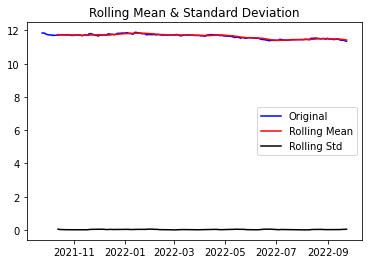

In [7]:
print('02 정성적 그래프 분석 =============================================================')
plot_rolling_statistics(ts_log, window=12)

In [8]:
print('03 정량적 Augmented Dicky-Fuller Test =============================================')
augmented_dickey_fuller_test(ts_log)

03 정량적 Augmented Dicky-Fuller Test =============================================
Results of Dickey-Fuller Test:
Test Statistic                  -0.662125
p-value                          0.856318
#Lags Used                       1.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64



04 시계열 분해 (Time Series Decomposition) 그래프 그리기 ==========================


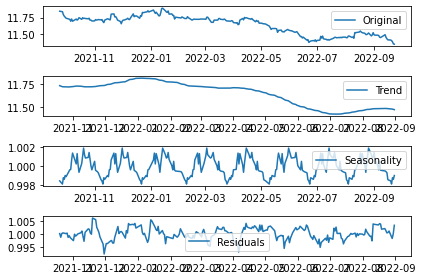

In [9]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print('04 시계열 분해 (Time Series Decomposition) 그래프 그리기 ==========================')
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [10]:
# Residual 안정성 확인
print('05 Residual 안정성 확인 ===========================================================')
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

05 Residual 안정성 확인 ===========================================================
Results of Dickey-Fuller Test:
Test Statistic                -5.931573e+00
p-value                        2.373779e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64



### STEP 4 : 학습, 테스트 데이터셋 생성

06 학습, 테스트 데이터셋 그리기 ===================================================


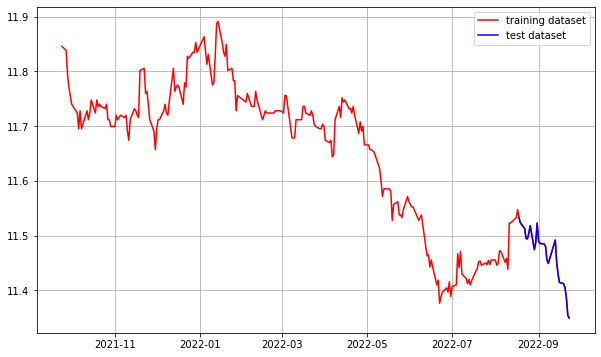

In [12]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

print('06 학습, 테스트 데이터셋 그리기 ===================================================')
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### STEP 5 : 적정 ARIMA 모수 찾기

07 ACF(Autocorrelation), PACF(Partial Autocorrelation) 그래프 그리기 ==============


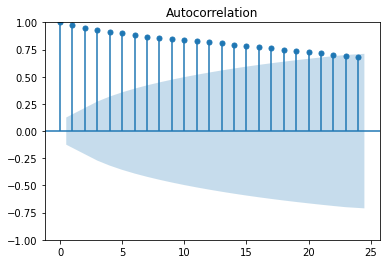

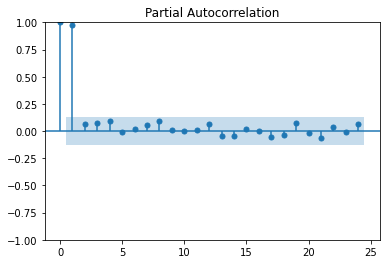

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print('07 ACF(Autocorrelation), PACF(Partial Autocorrelation) 그래프 그리기 ==============')
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

08 1차 차분 구하기 ================================================================


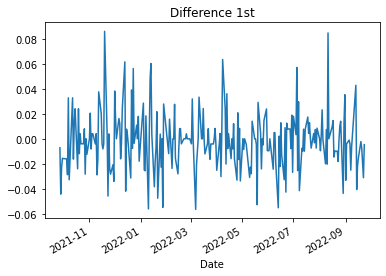

Results of Dickey-Fuller Test:
Test Statistic                -1.752616e+01
p-value                        4.260362e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64

09 2차 차분 구하기 ================================================================


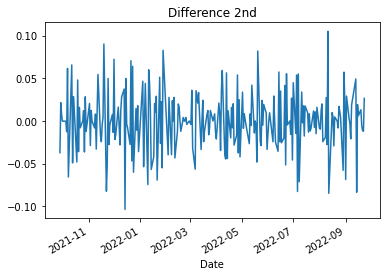

Results of Dickey-Fuller Test:
Test Statistic                -8.417584e+00
p-value                        2.024032e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64



In [14]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
print('08 1차 차분 구하기 ================================================================')
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
plt.show()
augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
print('09 2차 차분 구하기 ================================================================')
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
plt.show()
augmented_dickey_fuller_test(diff_2)


### STEP 6 : ARIMA 모델 훈련과 테스트

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [16]:
print('10 훈련 결과 ======================================================================')
print(fitted_m.summary())
print()

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


10 훈련 결과 ======================================================================
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 516.565
Date:                Sat, 24 Sep 2022   AIC                          -1023.130
Time:                        13:24:10   BIC                          -1006.162
Sample:                             0   HQIC                         -1016.278
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6748      0.084    138.555      0.000      11.510      11.840
ar.L1          0.1919      0.243      0.788      0.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


11 훈련과 예측결과 그리기 =========================================================


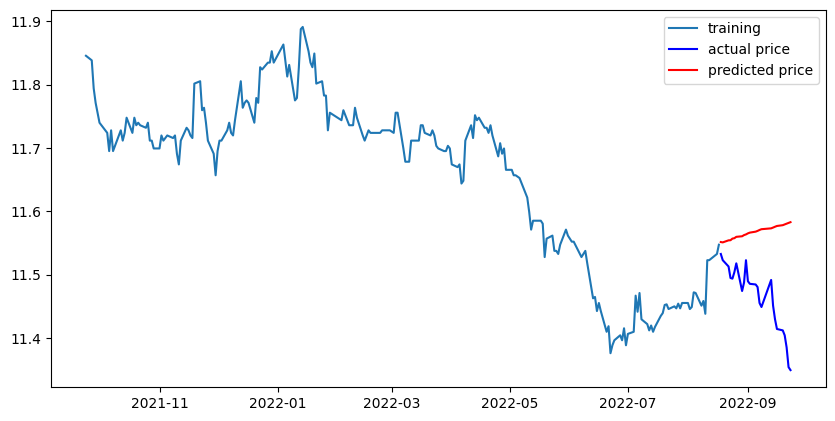

In [17]:
print('11 훈련과 예측결과 그리기 =========================================================')
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 전혀 맞지 않는군요 ㅠㅠ

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print('12 MSE, MAE, RMSE, MAPE 값 프린트 =================================================')
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

12 MSE, MAE, RMSE, MAPE 값 프린트 =================================================
MSE:  138206145.84268832
MAE:  10267.811348675425
RMSE:  11756.11099993056
MAPE: 11.11%


#### MAPE가 11%로 매우 크게 나타났다. 시계열 데이타만 가지고 주가예측하기는 어려운 모양이다.